## RWS VAE

In [37]:
import inspect
import os

import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import numpy as np
from jax import jit
from jax import lax
from jax import random
from jax.example_libraries import stax
from jax.random import PRNGKey
from numpyro import optim
from numpyro.examples.datasets import MNIST
from numpyro.examples.datasets import load_dataset
from tensorflow_probability.substrates import jax as tfp
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib import rcParams
from scipy.interpolate import griddata


import genjax
from genjax import grasp
from genjax import gensp
from genjax import select

import adevjax

console = genjax.pretty()
key = jax.random.PRNGKey(314159)
sns.set_theme(style="white")
font_path = (
    "/home/femtomc/.local/share/fonts/Unknown Vendor/TrueType/Lato/Lato_Bold.ttf"
)
font_manager.fontManager.addfont(font_path)
custom_font_name = font_manager.FontProperties(fname=font_path).get_name()
rcParams["font.family"] = custom_font_name
rcParams["figure.autolayout"] = True
label_fontsize = 70  # Set the desired font size here


def show_image(img):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(img, cmap="gray_r")


def save_images(imgs, path):
    fig = plt.figure(figsize=(8, 2))
    for i, img in enumerate(imgs):
        ax = plt.subplot(1, len(imgs), i + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(img, cmap="gray_r")
    # fig.savefig(path, format="pdf")


pytree_mean = lambda pytree: jtu.tree_map(lambda v: v.mean(axis=0), pytree)


hidden_dim = 400
z_dim = 10
learning_rate = 1.0e-4
batch_size = 64
num_epochs = 100  # 100
num_particles = 5

In [2]:
def encoder(hidden_dim, z_dim):  # q
    return stax.serial(
        stax.Dense(hidden_dim, W_init=stax.randn()),
        stax.Softplus,
        stax.FanOut(2),
        stax.parallel(
            stax.Dense(z_dim, W_init=stax.randn()),
            stax.serial(stax.Dense(z_dim, W_init=stax.randn()), stax.Exp),
        ),
    )


def decoder(hidden_dim, out_dim):  # p
    return stax.serial(
        stax.Dense(hidden_dim, W_init=stax.randn()),
        stax.Softplus,
        stax.Dense(out_dim, W_init=stax.randn()),
    )

In [3]:
encoder_nn_init, encoder_nn_apply = encoder(hidden_dim, z_dim)
decoder_nn_init, decoder_nn_apply = decoder(hidden_dim, 28 * 28)

# Model + guide close over the neural net apply functions.
@genjax.gen
def model(decoder_params):
    latent = genjax.tfp_mv_normal_diag(jnp.zeros(z_dim), jnp.ones(z_dim)) @ "latent"
    logits = decoder_nn_apply(decoder_params, latent)
    _ = genjax.tfp_bernoulli(logits) @ "image"


@genjax.gen
def guide(encoder_params, chm):
    image = chm["image"]
    μ, Σ_scale = encoder_nn_apply(encoder_params, image)
    _ = grasp.mv_normal_diag_reparam(μ, Σ_scale) @ "latent"

In [4]:
def rws_p_wake(
    p,
    p_params,
    q,
    q_params,
    nparticles,
    data_chm,
):
    posterior_approx = grasp.sir(nparticles, q, (q_params, data_chm))
    tgt = genjax.gensp.target(p, (p_params,), data_chm)

    @adevjax.adev
    def integrand(p_params, q_params):
        key = adevjax.reap_key()
        _, sample = posterior_approx.simulate(key, tgt)
        key = adevjax.reap_key()
        return -p.assess(key, sample.value, (p_params,))[1]

    return adevjax.E(integrand)

In [5]:
def rws_q_wake(
    p,
    p_params,
    q,
    q_params,
    nparticles,
    data_chm,
):
    posterior_approx = grasp.sir(nparticles, q, (q_params, data_chm))
    tgt = genjax.gensp.target(p, (p_params,), data_chm)

    @adevjax.adev
    def integrand(p_params, q_params):
        key = adevjax.reap_key()
        _, sample = posterior_approx.simulate(key, tgt)
        key = adevjax.reap_key()
        return -q.assess(key, sample.value, (q_params, data_chm))[1]

    return adevjax.E(integrand)

In [6]:
def rws_q_sleep(
    p,
    p_params,
    q,
    q_params,
    nparticles,
    _,
):
    p_sampler = lambda key: p.simulate(key, (p_params,)).strip()

    @adevjax.adev
    def integrand(p_params, q_params):
        key = adevjax.reap_key()
        sample = p_sampler(key)
        data_chm = genjax.choice_map({"image": sample["image"]})
        q_chm = genjax.choice_map({"latent": sample["latent"]})
        key = adevjax.reap_key()
        return -q.assess(key, q_chm, (q_params, data_chm))[1]

    return adevjax.E(integrand)

In [7]:
def make_batch_updater(
    p,  # model
    q,  # guide
    num_particles,
    optimizer,
):
    def rws_step(key, loss_factory, opt_state, batch):
        def loss_and_grad(key, data, p_params, q_params):
            data_chm = genjax.choice_map({"image": data.reshape((28 * 28,))})
            grasp_loss = loss_factory(p, p_params, q, q_params, num_particles, data_chm)
            loss, (p_grad, q_grad) = grasp_loss.value_and_grad_estimate(
                key, (p_params, q_params)
            )
            return loss, p_grad, q_grad

        subkeys = jax.random.split(key, len(batch))
        p_params, q_params = optimizer.get_params(opt_state)
        batched_loss_and_grad = jax.vmap(loss_and_grad, in_axes=(0, 0, None, None))
        losses, p_grads, q_grads = batched_loss_and_grad(
            subkeys, batch, p_params, q_params
        )
        p_grad, q_grad = pytree_mean((p_grads, q_grads))
        opt_state = optimizer.update((p_grad, q_grad), opt_state)
        return opt_state, losses.mean()

    def batch_updater(key, opt_state, batch):
        losses = []
        for (i, loss_factory) in enumerate((rws_p_wake, rws_q_wake)):
            subkey = jax.random.fold_in(key, idx)
            opt_state, loss = rws_step(subkey, loss_factory, opt_state, batch)
            losses.append(loss)
        return opt_state, losses

    return batch_updater

In [8]:
sgd = optim.Adam(learning_rate)
batch_updater = make_batch_updater(model, guide, num_particles, sgd)
train_init, train_fetch = load_dataset(MNIST, batch_size=batch_size, split="train")
num_train, train_idx = train_init()
rng_key = PRNGKey(0)
encoder_init_key, decoder_init_key = random.split(rng_key)
_, encoder_params = encoder_nn_init(encoder_init_key, (784,))
_, decoder_params = decoder_nn_init(decoder_init_key, (z_dim,))
num_train, train_idx = train_init()

In [9]:
# @jit
def binarize(rng_key, batch):
    return random.bernoulli(rng_key, batch).astype(batch.dtype)


# @jit
def epoch_train(opt_state, key1, key2, train_idx):
    def body_fn(carry, xs):
        idx, opt_state = carry
        rng_key_binarize = random.fold_in(key1, idx)
        batch = binarize(rng_key_binarize, train_fetch(idx, train_idx)[0])
        updater_key = random.fold_in(key2, idx)
        opt_state, losses = batch_updater(updater_key, opt_state, batch)
        idx += 1
        return (idx, opt_state), losses

    (_, opt_state), losses = lax.scan(body_fn, (0, opt_state), None, length=num_train)
    return opt_state, losses


# Train.
key = random.PRNGKey(314159)
opt_state = sgd.init((decoder_params, encoder_params))
epoch_losses = []
for idx in range(0, num_epochs):
    key, key1, key2 = jax.random.split(key, 3)
    num_train, train_idx = train_init()
    opt_state, losses = epoch_train(opt_state, key1, key2, train_idx)
    mean_losses = pytree_mean(losses)
    print("epoch {} p_wake={:.5} q_wake={:.5}".format(idx, *mean_losses))
    epoch_losses.append(mean_losses)

epoch 0 p_wake=232.3 q_wake=14.189
epoch 1 p_wake=208.41 q_wake=13.503
epoch 2 p_wake=205.94 q_wake=13.391
epoch 3 p_wake=197.78 q_wake=12.569
epoch 4 p_wake=189.88 q_wake=11.543
epoch 5 p_wake=178.58 q_wake=10.397
epoch 6 p_wake=169.64 q_wake=9.1712
epoch 7 p_wake=160.76 q_wake=7.9713
epoch 8 p_wake=153.99 q_wake=6.9752
epoch 9 p_wake=150.27 q_wake=6.4781
epoch 10 p_wake=147.17 q_wake=5.9381
epoch 11 p_wake=144.02 q_wake=5.4241
epoch 12 p_wake=140.82 q_wake=4.7583
epoch 13 p_wake=138.11 q_wake=4.3226
epoch 14 p_wake=135.53 q_wake=3.8976
epoch 15 p_wake=132.68 q_wake=3.248
epoch 16 p_wake=130.4 q_wake=2.8768
epoch 17 p_wake=128.35 q_wake=2.5814
epoch 18 p_wake=126.48 q_wake=2.1152
epoch 19 p_wake=125.1 q_wake=1.9187
epoch 20 p_wake=123.81 q_wake=1.6205
epoch 21 p_wake=122.8 q_wake=1.4495
epoch 22 p_wake=122.0 q_wake=1.2991
epoch 23 p_wake=121.21 q_wake=1.1826
epoch 24 p_wake=120.57 q_wake=1.1116
epoch 25 p_wake=119.93 q_wake=0.974
epoch 26 p_wake=119.3 q_wake=0.81625
epoch 27 p_wake=11

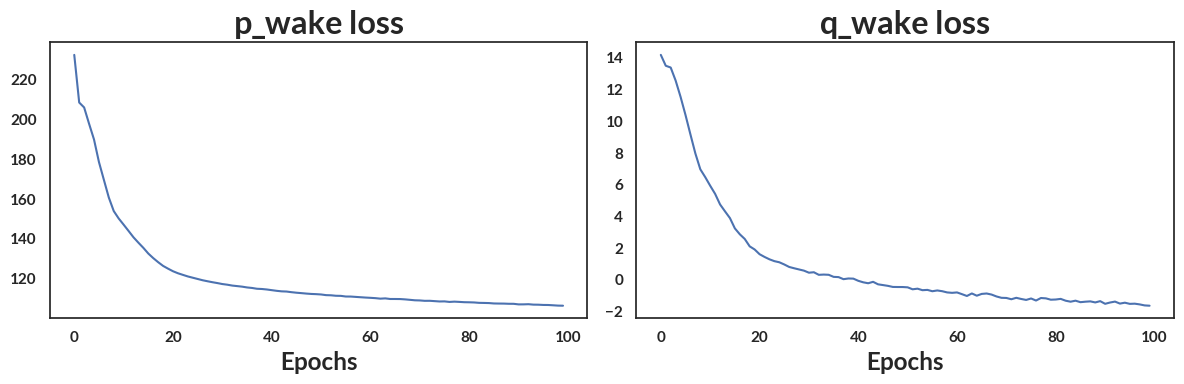

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for (i, (ax, title)) in enumerate(zip(axs, ("p_wake", "q_wake"))):
    ax.plot([l[i] for l in epoch_losses])
    ax.set_xlabel("Epochs", fontsize=label_fontsize / 4)
    ax.yaxis.labelpad = 24  # adjust the value as needed
    ax.set_title(title + " loss", fontsize=label_fontsize / 3)

In [13]:
def generate_images(key, n_images, opt_state):
    images = []
    for i in range(0, n_images):
        key, sub_key = jax.random.split(key)
        updated_decoder_params, _ = sgd.get_params(opt_state)
        latent = genjax.tfp_mv_normal_diag.sample(
            key, jnp.zeros(z_dim), jnp.ones(z_dim)
        )
        updated_out = jax.nn.sigmoid(
            decoder_nn_apply(updated_decoder_params, latent)
        ).reshape(28, 28)
        images.append(updated_out)
    return images

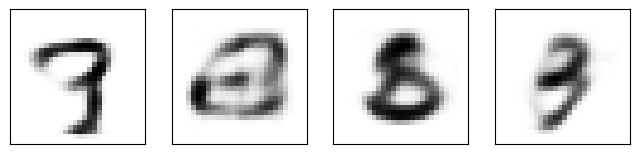

In [36]:
key, sub_key = jax.random.split(key)
imgs = generate_images(sub_key, 4, opt_state)
save_images(imgs, "img/elbo_samples.pdf")